# BASICS 02 - Training the network

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd '../HOTS'

/home/INT/grimaldi.a/Documents/projets/HOTS/newhots/HOTS


## Loading events

In [23]:
import tonic.datasets as datasets
import tonic.transforms as transforms
from torch.utils.data import SubsetRandomSampler, DataLoader
from torch import Generator
import numpy as np

def get_loader(train = True, kfold = None, kfold_ind = 0, num_workers = 0, seed=42):
    # creates a loader for the samples of the dataset. If kfold is not None, 
    # then the dataset is splitted into different folds with equal repartition of the classes.
    # works for NMNIST
    dataset = datasets.POKERDVS(save_to='../../Data',
                                    train=train, 
                                    transform = transforms.NumpyAsType(int))
    if kfold:
        subset_indices = []
        subset_size = len(dataset)//kfold
        for i in range(len(dataset.classes)):
            all_ind = np.where(np.array(dataset.targets)==i)[0]
            subset_indices += all_ind[kfold_ind*subset_size//len(dataset.classes):
                            min((kfold_ind+1)*subset_size//len(dataset.classes), len(dataset)-1)].tolist()
        g_cpu = Generator()
        g_cpu.manual_seed(seed)
        subsampler = SubsetRandomSampler(subset_indices, g_cpu)
        loader = DataLoader(dataset, batch_size=1, shuffle=False, sampler=subsampler, num_workers = num_workers)
    else:
        loader = DataLoader(dataset, shuffle=True, num_workers = num_workers)
    return loader, dataset.ordering, dataset.classes

In [27]:
loader, order, classes = get_loader(kfold=10)
print(f'Size of Dataloader: {len(loader)} samples')

Size of Dataloader: 4 samples


## Network definition and training

 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 1/4 [08:30<25:30, 510.13s/it]

loading a network with name:
 ../Records/models/2021-12-14_poker_homhots_(2, 1)_[4, 8, 16]_[0.7, 1.4, 2.8]_[2, 4, 8].pkl


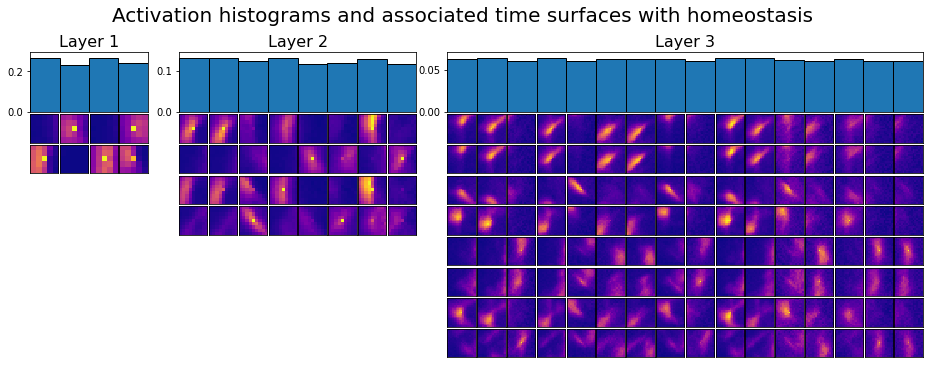

In [25]:
from Network import network
hots = network(name = 'homhots', tau = (0.7,1.4,2.8), homeo = (2,1), 
               timestr = '2021-11-25_poker', to_record=True)
hots.running(loader, order, classes, learn=True, train=train)
hots.plotlayer();

Text(0, 0.5, '$\\Delta w/w$')

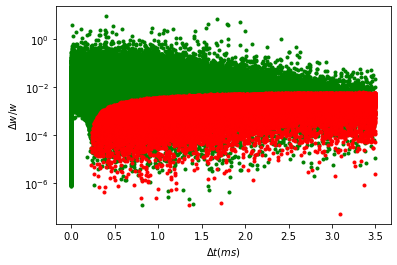

In [16]:
import matplotlib.pyplot as plt

layer = 0

dw_pos = hots.stats[layer].delta_wt[hots.stats[layer].delta_wt[:,0] > 0, 0]/hots.stats[layer].delta_wt[hots.stats[layer].delta_wt[:,0] > 0, 3]
dw_neg = hots.stats[layer].delta_wt[hots.stats[layer].delta_wt[:,0] < 0, 0]/hots.stats[layer].delta_wt[hots.stats[layer].delta_wt[:,0] < 0, 3]
dt_pos = hots.stats[layer].delta_wt[hots.stats[layer].delta_wt[:,0] > 0, 1]
dt_neg = hots.stats[layer].delta_wt[hots.stats[layer].delta_wt[:,0] < 0, 1]

plt.semilogy(dt_pos[dw_pos<10]*1e-3, dw_pos[dw_pos<10],'. g')
plt.plot(dt_neg*1e-3, -dw_neg,'. r')
plt.xlabel('$\Delta t (ms)$')
plt.ylabel('$\Delta w/w$')

/tmp/ipykernel_1272435/987668717.py:2: RuntimeWarning: invalid value encountered in true_divide
  dw = hots.stats[layer].delta_wt[:, 0]/hots.stats[layer].delta_wt[:, 3]


Text(0, 0.5, '$\\Delta w / w$')

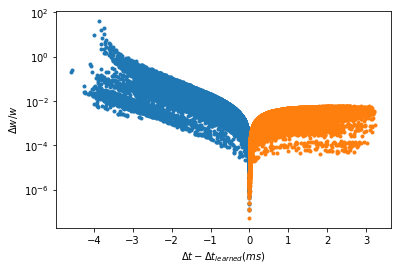

In [17]:
dt_XTS = hots.stats[layer].delta_wt[:, 1]-hots.stats[layer].delta_wt[:, 2]
dw = hots.stats[layer].delta_wt[:, 0]/hots.stats[layer].delta_wt[:, 3]
plt.semilogy(dt_XTS*1e-3,dw, '.')
plt.semilogy(dt_XTS*1e-3,-dw, '.')
plt.xlabel('$\Delta t - \Delta t_{learned} (ms)$')
plt.ylabel('$\Delta w / w$')

/tmp/ipykernel_1272435/1359442766.py:1: RuntimeWarning: divide by zero encountered in log
  dt_XTS = np.log(hots.stats[layer].delta_wt[1:, 1]/hots.stats[layer].delta_wt[1:, 2])


Text(0, 0.5, '$\\Delta w / w$')

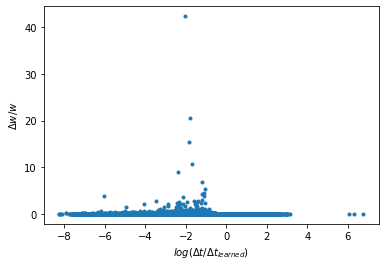

In [18]:
dt_XTS = np.log(hots.stats[layer].delta_wt[1:, 1]/hots.stats[layer].delta_wt[1:, 2])
dw = hots.stats[layer].delta_wt[1:, 0]/hots.stats[layer].delta_wt[1:, 3]
plt.plot(dt_XTS,dw, '.')
#plt.semilogy(dt_XTS,-dw, '.')
plt.xlabel('$log(\Delta t / \Delta t_{learned})$')
plt.ylabel('$\Delta w / w$')

loading a network with name:
 ../Records/models/2021-11-25_poker_hots_None_[4, 8, 16]_[0.7, 1.4, 2.8]_[2, 4, 8].pkl


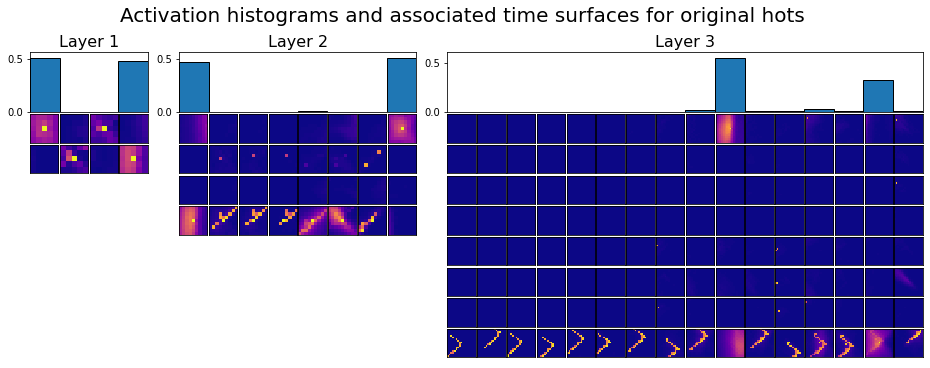

In [19]:
hots = network(name = 'hots', tau = [0.7, 1.4, 2.8],  
               timestr = '2021-11-25_poker', to_record=True)
hots.running(loader, order, classes, learn=True, train=train)
hots.plotlayer();

## Running network
### Training set

In [28]:
from Tools import save_output, load_output
from os.path import isfile

loader, order, classes = get_loader()
print(f'Size of Dataloader: {len(loader)} samples')
train = True 
nb = len(loader)
jitonic = None

Size of Dataloader: 48 samples




  0%|                                                                                                                                                                                                                                                  | 0/48 [00:00<?, ?it/s]

  4%|█████████▊                                                                                                                                                                                                                                | 2/48 [00:02<01:07,  1.47s/it]

  6%|██████████████▋                                                                                                                                                                                                                           | 3/48 [00:06<01:51,  2.47s/it]

  8%|███████████████████▌                                                                                                                                                             

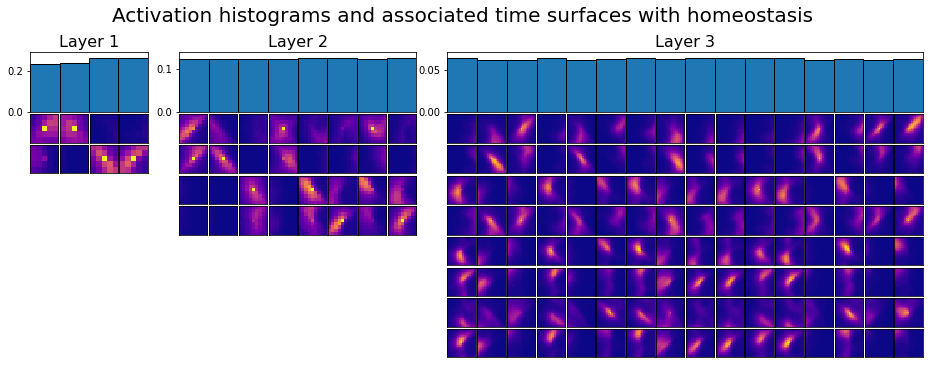

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [02:01<00:00,  2.54s/it]


In [31]:
hots = network(name = 'homhots', tau = (0.7,1.4,2.8), homeo = (2,1), 
               timestr = '2021-12-14_poker')
hots.running(loader, order, classes, train=train, learn=True)
hots.plotlayer();
hots.running(loader, order, classes, train=train)

### Testing set

In [32]:
loader, order, classes = get_loader(train=False)
train = False 
nb = len(loader)
print(f'Size of Dataloader: {len(loader)} samples')

Size of Dataloader: 20 samples


In [33]:
hots.running(loader, order, classes, train=train)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:53<00:00,  2.66s/it]


# TODO:
- find an entropy measure for the (not histograms) kernels -> then method to get hom_param (+ measure of the balance between strengh of the gain and homeostasis)
- find a way to tune the hyper-parameters as a function of the signal
- make a good recordings of the network characterisitics during learning (check for STDP, loss, weight update strengh)
- think about how to save/output data (tonic format -> easy to use and exchange)
- have some easy to implement methods for:
    - training a network
        - unsupervised (done)
        - supervised
    - running a network (ouptut is classification result or stream of events, make a flag for the last layer)
    - learning rule for the classification layer (spiking mechanism==same as in HOTS)
    - get results of the paper:
        - online classification results
        - histogram classification 
        - adding jitter
- try the averaged time surface to separate movement and object
- try to add a threshold
- try with alpha instead of exponential decay
- what happens with sigma
- try to make a stride within the network